Data is collected at location Nes, Ameland.
The data is from water hight and water temperature.

The research question states:
How does the independent variable water temperature influence the dependent variable of water hight?

H0: There is no effect on water hight caused by the water temperature
H1: There is a effect on water hight caused by the water temperature

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, time
from scipy.stats import f_oneway
import seaborn as sns

In [99]:
#Please put the file locations here:

WaveHightFile = "FilePathHight"
WaterTemperatureFile = "FilePathTemp"

#Example:
#WaveHightFile = "C:\\Users\\Pin\\Desktop\\DataSets\\NVT_Hight_NES.csv"
#WaterTemperatureFile = "C:\\Users\\Pin\\Desktop\\DataSets\\NVT_Temp_NES.csv"

In [100]:
def LoadData(Path):
    DataFrame = pd.read_csv(Path, sep = ";", header = 0)
    return DataFrame

In [101]:
def PrintAll(DataFrame):
    """
    Usefull function to print the entire Dataframe or selected column of it
    """
    with pd.option_context("display.max_rows", None, "display.max_columns", None, "display.max_colwidth", None):
        print(DataFrame)

In [102]:
def Cleanup(DataFrame):
    """
    Removes columns without any values
    Drops columns with no meaningfull values
    Drops rows with any nan value
    """
    DataFrame = DataFrame.dropna(how = "all", axis = "columns")
    DataFrame = DataFrame.drop(columns = {"Referentievlak","Bemonsteringshoogte"})
    DataFrame = DataFrame.dropna(axis = 0, how = "any")
    return DataFrame

In [103]:
def Translate(DataFrame):
    """
    Translates all dutch to english
    Replaces oC with °C
    """
    degree_sign = u"\N{DEGREE SIGN}"
    Rename_dict = {"Datum":"Date",
                   "Tijd":"Time",
                   "Locatie":"Location",
                   "Waarde":"Value",
                   "Eenheid":"Unit",
                   "Windrichting":"Winddirection",
                   "Windrichting eenheid":"Wind direction unit"}
    DataFrame = DataFrame.rename(columns = Rename_dict)
    DataFrame = DataFrame.replace(["Significante golfhoogte in het spectrale domein Oppervlaktewater golffrequentie tussen 30 en 500 mHz in cm", "Temperatuur Oppervlaktewater oC", "graden", "oC"],
                                   ["Significant wave height in the spectral domain Surface water wave frequency between 30 and 500 mHz in cm","Temperature surface water " + degree_sign + "C", "Degrees", degree_sign + "C"])
    return DataFrame

In [104]:
def CombineAndDrop(DataFrame):
    """
    Renames columns to add their unit
    Removes columns that are not used, like the seperate unit column
    """
    Unused = {"Parameter", "Location", "Unit", "Wind direction unit", "Winddirection in Degrees"}
    DataFrame = DataFrame.replace("Significant wave height in the spectral domain Surface water wave frequency between 30 and 500 mHz in cm","Wave hight in cm")
    Rename_dict = {"Value": DataFrame["Parameter"].iloc[0],
                   "Winddirection": "Winddirection in " + DataFrame["Wind direction unit"].iloc[0]}
    DataFrame = DataFrame.rename(columns = Rename_dict)
    DataFrame = DataFrame.drop(columns = Unused)
    
    return DataFrame

In [105]:
def AddTime(DataFrame):
    """
    Adds the time column to the date column
    """
    DataFrame["DateTime"] = DataFrame["Date"] + " " + DataFrame["Time"]
    DataFrame = DataFrame.drop(columns = {"Date", "Time"})
    return DataFrame

In [106]:
def ConvertToNumeric(DataFrame):
    """
    Replaces , with . and then converts the column to numeric
    """
    DataFrame = DataFrame.replace(",", ".", regex = True)
    DataFrame = DataFrame.apply(lambda col:pd.to_numeric(col, errors="ignore"))#errors = ignore so it lets strings remain as non-null objects.
    return DataFrame

In [107]:
def CombineFrames(DataFrame1, DataFrame2, NameDataFrame1, NameDataFrame2):
    DataFrame1 = DataFrame1.set_index("DateTime")
    DataFrame2 = DataFrame2.set_index("DateTime")
    DataFrameComb = pd.merge(DataFrame1, DataFrame2, left_index = True, right_index = True, suffixes = ("_" + NameDataFrame1, "_" + NameDataFrame2))
    return DataFrameComb

In [108]:
def Preproccessing(DataFrame):
    DataFrame = Cleanup(DataFrame)
    DataFrame = Translate(DataFrame)
    DataFrame = CombineAndDrop(DataFrame)
    DataFrame = AddTime(DataFrame)
    DataFrame = ConvertToNumeric(DataFrame)

    return DataFrame

In [109]:
def ReGroup(Frame):
    """
    Cuts the dataframe into 3 equal sized dataframes based on the temperature column
    Removed temperature column
    Renames the water hight column to add temperature range
    """
    Size = round(len(Frame) / 3)
    Size2 = round(len(Frame) / 3 * 2)
    Frame = Frame.sort_values("Temperature surface water °C")
    Frame = Frame.reset_index(drop = True)


    Temp1 = Frame.iloc[:Size,:]
    T1Max = Temp1["Temperature surface water °C"].max()
    T1Min = Temp1["Temperature surface water °C"].min()
    Temp1 = Temp1.rename(columns = {"Wave hight in cm":"Wave hight in cm " + str(T1Min) + " - " + str(T1Max) + "°C"}).reset_index(drop = True)

    Temp2 = Frame.iloc[Size:Size2,:]
    T2Max = Temp2["Temperature surface water °C"].max()
    T2Min = Temp2["Temperature surface water °C"].min()
    Temp2 = Temp2.rename(columns = {"Wave hight in cm":"Wave hight in cm " + str(T2Min) + " - " + str(T2Max) + "°C"}).reset_index(drop = True)

    Temp3 = Frame.iloc[Size2:,:]
    T3Max = Temp3["Temperature surface water °C"].max()
    T3Min = Temp3["Temperature surface water °C"].min()
    Temp3 = Temp3.rename(columns = {"Wave hight in cm":"Wave hight in cm " + str(T3Min) + " - " + str(T3Max) + "°C"}).reset_index(drop = True)

    FrameGroupAll = pd.concat([Temp1, Temp2, Temp3], axis = 1)
    FrameGroupAll = FrameGroupAll.drop(columns = "Temperature surface water °C")
    FrameGroupAll = FrameGroupAll.dropna(axis = 0, how = "any")
    
    return FrameGroupAll

In [110]:
Hight = LoadData(WaveHightFile)
Temp = LoadData(WaterTemperatureFile)

Hight = Preproccessing(Hight)
Temp = Preproccessing(Temp)
Frame = CombineFrames(Hight, Temp, "Hight", "Temp")
CutFrame = ReGroup(Frame)

<AxesSubplot:title={'center':'Wave hight over time'}, xlabel='Time', ylabel='Hight in cm'>

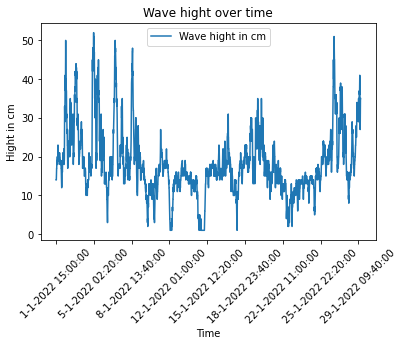

In [111]:
Hight.plot(x = "DateTime", y = "Wave hight in cm", title = "Wave hight over time", xlabel = "Time", ylabel = "Hight in cm", rot = 45)

<AxesSubplot:title={'center':'Surface water temperature over time'}, xlabel='Time', ylabel='Temp in °C'>

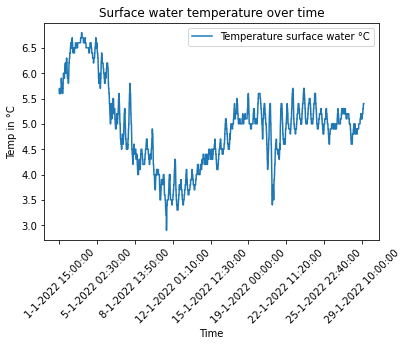

In [112]:
Temp.plot(x = "DateTime", y = "Temperature surface water °C", title = "Surface water temperature over time", xlabel = "Time", ylabel = "Temp in °C", rot = 45)

<function matplotlib.pyplot.show(close=None, block=None)>

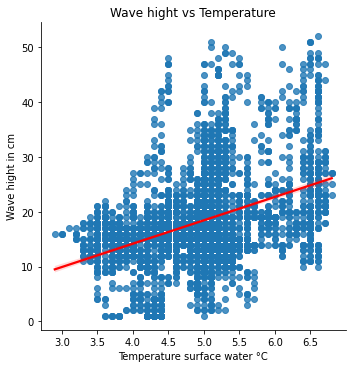

In [113]:
sns.lmplot(x="Temperature surface water °C", y="Wave hight in cm", data=Frame, fit_reg=True, line_kws = {"color": "red"})
plt.title("Wave hight vs Temperature")
plt.show

In [115]:
print("2.9 - 4.6°C", CutFrame["Wave hight in cm 2.9 - 4.6°C"].mean(), "\n",
"4.6 - 5.2°C", CutFrame["Wave hight in cm 4.6 - 5.2°C"].mean(), "\n",
"5.2 - 6.8°C", CutFrame["Wave hight in cm 5.2 - 6.8°C"].mean())

2.9 - 4.6°C 14.602086438152012 
 4.6 - 5.2°C 17.870342771982116 
 5.2 - 6.8°C 22.086438152011922


In [116]:
#One way anova on 3 equal sized groups.
#Wave hight grouped by temperature range
statistic, pvalue = f_oneway(CutFrame["Wave hight in cm 2.9 - 4.6°C"], CutFrame["Wave hight in cm 4.6 - 5.2°C"], CutFrame["Wave hight in cm 5.2 - 6.8°C"])

In [117]:
print("Statistic = ", statistic, "\n", "pvalue = ", pvalue)

Statistic =  302.50165780899283 
 pvalue =  4.1024242637547626e-123


The one way anova gives a pvalue below 0.05, this indicates that there is a significant difference between the groups.

H1 is accepted. There is a significant effect on water hight caused by the water temperature.

